In [1]:
import os
import pandas as pd
import numpy as np

import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import pearsonr,spearmanr
import warnings
warnings.filterwarnings("ignore")#忽略警告

import datetime
from collections import Counter
from scipy import stats
from sklearn.preprocessing import MinMaxScaler,StandardScaler
# from calendar import day_abbr, month_abbr, mdays
# import holidays
# from fbprophet import Prophet
from sklearn.metrics import mean_squared_error as MSE, r2_score as R2, mean_absolute_percentage_error as MAPE
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
from sklearn import svm
import joblib

from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor

In [2]:
df=pd.read_csv('./data/preprocessed/data.csv')

In [3]:
df['Date']=pd.to_datetime(df['Date'].astype('str'))
df.set_index('Date',drop=True,inplace=True)

In [4]:
x = df.iloc[:,1:]  # features
x_train=x.loc[:'2022-02-28',:]
x_test=x.loc['2022-03-01':,:]
y = df.loc[:, ['Price']]  # target
y_train=y.loc[:'2022-02-28',:]
y_test=y.loc['2022-03-01':,:]

In [5]:
# Pre-process data
scaler = MinMaxScaler() 
x_train1 = scaler.fit_transform(x_train)
x_test1 = scaler.transform(x_test)
scaler = StandardScaler()
x_train2 = scaler.fit_transform(x_train)
x_test2 = scaler.transform(x_test)

### XGBoost without time offset

In [6]:
x.isnull().any()

GDP          False
netimport    False
EV           False
EG           False
carbon       False
crude        False
gas          False
temp         False
precip       False
wind         False
dtype: bool

In [7]:
def XGB(X,Y):    
    for n in X.iloc[:,0:]:
        # Training data
        x = pd.DataFrame(X[str(n)] ) # features
        x_train=x.loc[:'2022-02-28',:]
        X_test=x.loc['2022-03-01':,:]
        y_train=y.loc[:'2022-02-28',:]
        y_test=y.loc['2022-03-01':,:]
        # Train the model
        scaler = StandardScaler() 
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(X_test)
        model = XGBRegressor()
        model.fit(x_train, y_train)

        # Store the fitted values as a time series with the same time index as
        # the training data
        y_pred = pd.Series(model.predict(x_test).T[0], index=X_test.index)
        print(str(n),'\nMSE:',MSE(y_test,y_pred),'\nr2_score:', R2(y_test,y_pred),'\nMAPE:', MAPE(y_test,y_pred),'\n')


In [8]:
XGB(x,y)

GDP 
MSE: 651.9847726476422 
r2_score: -0.02082117859249344 
MAPE: 0.8156187502205131 

netimport 
MSE: 665.9556850862406 
r2_score: -0.042695620910627285 
MAPE: 0.8649770183615586 

EV 
MSE: 1485.802893779847 
r2_score: -1.326341234972653 
MAPE: 0.7132206398803601 

EG 
MSE: 1091.7834029078733 
r2_score: -0.7094197086815484 
MAPE: 0.4220850187492764 

carbon 
MSE: 650.4894650695269 
r2_score: -0.018479955747592536 
MAPE: 0.8091365174464077 

crude 
MSE: 1082.685894669295 
r2_score: -0.6951756197519143 
MAPE: 0.41847430555920945 

gas 
MSE: 877.5709047395366 
r2_score: -0.3740243681409452 
MAPE: 0.4100248626401748 

temp 
MSE: 948.5121315017695 
r2_score: -0.48509798481474675 
MAPE: 0.39551238283168777 

precip 
MSE: 815.5276053311482 
r2_score: -0.2768823539668399 
MAPE: 0.4350372778156824 

wind 
MSE: 796.0610237742009 
r2_score: -0.2464032698504548 
MAPE: 0.4444697680386107 



In [9]:
xtrain=x_train.copy()
xtest=x_test.copy()
ytrain=y_train.copy()
ytest=y_test.copy()

In [10]:
X_train=xtrain.loc[:,['EV','netimport']]
X_test=xtest.loc[:,['EV','netimport']]
# Train the model
scaler = StandardScaler() 
x_train = scaler.fit_transform(X_train)
x_test = scaler.transform(X_test)
model = XGBRegressor()
model.fit(X_train, ytrain)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X_test).T[0], index=xtest.index)
print('MSE:',MSE(ytest,y_pred),'\nr2_score:', R2(ytest,y_pred),'\nMAPE:', MAPE(ytest,y_pred),'\n')

MSE: 1037.536600046929 
r2_score: -0.6244847722312592 
MAPE: 0.4068050347856131 



In [11]:
y_pred.name='Price_pred'

In [12]:
ytest.name='Price_true'

In [13]:
res=pd.concat([X_test,ytest,y_pred],axis=1)

In [14]:
res

,EV,netimport,Price,Price_pred
Date,,,,
2022-03-01,26.068586,-24.325249,13.68,16.296967
2022-03-02,25.936845,-24.314318,13.28,16.296967
2022-03-03,25.804540,-24.303359,20.63,16.296967
2022-03-04,25.671671,-24.292371,23.72,16.296967
2022-03-05,25.538237,-24.281355,14.89,16.296967
...,...,...,...,...
2022-04-26,17.801233,-23.672716,23.94,16.296967
2022-04-27,17.636705,-23.660389,43.43,16.296967
2022-04-28,17.471570,-23.648040,19.30,16.296967


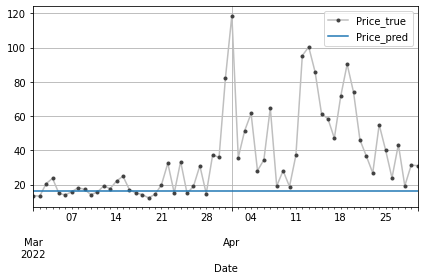

In [15]:
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=True,
    linewidth=1.5
)
ytest.columns=['Price_true']
ytest.plot(**plot_params)
y_pred.plot(label='Price_pred')
plt.legend(loc='best')
plt.grid()
plt.tight_layout()

### XGBoost regression with time offset

#### autoregression

In [16]:
shift=1
Df=df.copy()
Df['Lag_1'] = Df['Price'].shift(shift)
Df = Df.reindex(columns=['Price', 'Lag_1'])
X = Df.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = Df.loc[:, ['Price']]  # create the target
y, X = y.align(X, join='inner',axis=0)  # drop corresponding values in target

In [17]:
y

,Price
Date,
2019-01-02,42.65
2019-01-03,51.90
2019-01-04,50.85
2019-01-05,50.72
2019-01-06,51.02
...,...
2022-04-26,23.94
2022-04-27,43.43
2022-04-28,19.30


In [18]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)

In [50]:
def XGBshift():  
    for shift in range(1,32):
        Df=df.copy()
        X=make_lags(pd.DataFrame(df.Price), lags=shift).dropna()
        y=pd.DataFrame(df.Price)
        y, X = y.align(X, join='inner', axis=0)
        
        x_train=X.loc[:'2022-02-28',:]
        x_test=X.loc['2022-03-01':,:]
        
#         scaler = MinMaxScaler() 
#         x_train = scaler.fit_transform(x_train)
#         x_test = scaler.transform(x_test)
        
        y_train=y.loc[:'2022-02-28',:]
        y_test=y.loc['2022-03-01':,:]
        model = XGBRegressor(n_estimators=1000, learning_rate=0.2)
        model.fit(x_train, y_train)

        y_pred = pd.Series(model.predict(x_test), index=x_test.index)
        print('MSE:',MSE(y_test,y_pred),'\nr2_score:', R2(y_test,y_pred),'\nMAPE:', MAPE(y_test,y_pred),'\n')

In [51]:
XGBshift()

MSE: 852.3601581082822 
r2_score: -0.33455156882263615 
MAPE: 0.4948504593799692 

MSE: 756.9998475502974 
r2_score: -0.18524466979884902 
MAPE: 0.490206116442119 

MSE: 669.6315139910639 
r2_score: -0.048450914825986846 
MAPE: 0.44310405464811137 

MSE: 635.7637401379494 
r2_score: 0.004576306470368441 
MAPE: 0.43572241380624294 

MSE: 568.9661361891413 
r2_score: 0.1091621981212898 
MAPE: 0.43499010917156644 

MSE: 448.0440737325133 
r2_score: 0.2984914700512673 
MAPE: 0.44137104800070054 

MSE: 497.0180162889951 
r2_score: 0.22181232069351486 
MAPE: 0.43891310316440546 

MSE: 552.2000983224901 
r2_score: 0.1354130052771969 
MAPE: 0.4241257623061033 

MSE: 533.6572875747537 
r2_score: 0.16444572922418965 
MAPE: 0.4473049194697271 

MSE: 577.7448153170225 
r2_score: 0.09541730414559535 
MAPE: 0.46047154689473707 

MSE: 578.1784106605635 
r2_score: 0.0947384181835379 
MAPE: 0.45733414801541605 

MSE: 533.3160792562361 
r2_score: 0.16497996359969547 
MAPE: 0.46096379182346026 

MSE: 564

In [21]:
Df=df.copy()
X=make_lags(pd.DataFrame(df.Price), lags=2).dropna()
y=pd.DataFrame(df.Price)
y, X = y.align(X, join='inner', axis=0)

In [22]:
# x_trainl=X.loc['2019-01-02':'2022-01-31',:]
# x_testl=X.loc['2022-02-01':'2022-04-30',:]
# y_trainl=y.loc['2019-01-02':'2022-01-31',:]
# y_testl=y.loc['2022-02-01':'2022-04-30',:]
x_trainl=X.loc[:'2022-02-28',:]
x_testl=X.loc['2022-03-01':,:]
y_trainl=y.loc[:'2022-02-28',:]
y_testl=y.loc['2022-03-01':,:]

In [23]:
model = XGBRegressor()
model.fit(x_trainl, y_trainl)

y_predl = pd.Series(model.predict(x_testl).T[0], index=x_testl.index)

In [24]:
print('MSE:%f, r2 score:%f and MAPE:%f' %(MSE(y_testl,y_predl), R2(y_testl,y_predl),MAPE(y_testl,y_predl)))

MSE:977.114769, r2 score:-0.529882 and MAPE:0.396837


In [25]:
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
    linewidth=1.5
)

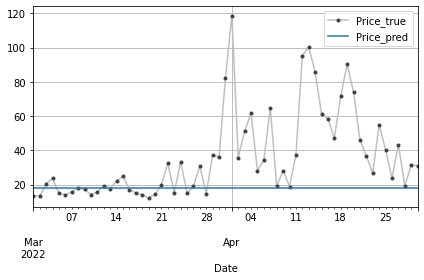

In [26]:
y_testl.columns=['Price_true']
ax = y_testl.plot(**plot_params)
ax = y_predl.plot(label='Price_pred')
plt.grid()
plt.legend(loc='best')
plt.tight_layout()

#### regression with elements

In [27]:
def XGB2(Df,n):
    df=Df.copy()
    df['Lag_1'] = df['Price'].shift(1)
    df['Lag '+n] = df[n].shift(1)
    df1 = df.reindex(columns=['Price','Lag'+n, 'Lag_1'])
    X = df.loc[:, ['Lag '+n,'Lag_1']]
    X.dropna(inplace=True)  # drop missing values in the feature set
    y = df.loc[:, ['Price']]  # create the target
    y, X = y.align(X, join='inner',axis=0)  # drop corresponding values in target
#     x_train=X.loc['2019-01-02':'2022-01-31',:]
#     x_test=X.loc['2022-02-01':'2022-04-30',:]
#     y_train=y.loc['2019-01-02':'2022-01-31',:]
#     y_test=y.loc['2022-02-01':'2022-04-30',:]
    x_train=X.loc[:'2022-02-28',:]
    x_test=X.loc['2022-03-01':,:]
    y_train=y.loc[:'2022-02-28',:]
    y_test=y.loc['2022-03-01':,:]
    scaler = MinMaxScaler() 
    x_train1 = scaler.fit_transform(x_train)
    x_test1 = scaler.transform(x_test)
    scaler = StandardScaler()
    x_train2 = scaler.fit_transform(x_train)
    x_test2 = scaler.transform(x_test)

    model = XGBRegressor()
    model.fit(x_train1, y_train)

    y_pred = pd.Series(model.predict(x_test1).T[0], index=x_test.index)
    print('MSE:%f, r2 score:%f and MAPE:%f \n' %(MSE(y_test,y_pred), R2(y_test,y_pred),MAPE(y_test,y_pred)))

    fig, ax = plt.subplots()
    ax = sns.regplot(x='Lag '+n, y='Price', data=df, ci=None, scatter_kws=dict(color='0.25'))
    ax.set_title('Lag '+n+' of Power Price')
    
#     plt.plot(x_test['Lag'+n],y_test, '.', color='0.25')
#     plt.plot(x_test['Lag'+n],y_pred)
# #     plt.set_aspect('equal')
#     plt.ylabel('Price')
#     plt.xlabel('Lag '+n)
#     plt.title('Lag Plot of Power Price');
    
    plot_params = dict(
        color="0.75",
        style=".-",
        markeredgecolor="0.25",
        markerfacecolor="0.25",
        legend=False,
        linewidth=1.5
    )
    y_test.plot(**plot_params)
    y_pred.plot()
    plt.grid()
    plt.tight_layout()

MSE:1062.527451, r2 score:-0.663613 and MAPE:0.412412 



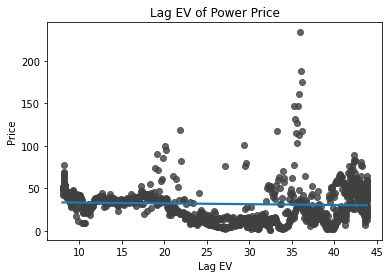

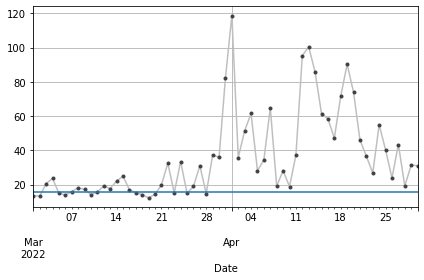

In [28]:
XGB2(df,'EV')

In [29]:
def XGB3(Df,n):
    df=Df.copy()
    for m in range(1,31):
        df['Lag_1'] = df['Price'].shift(1)
        df['Lag_2'] = df['Price'].shift(2)
        df['Lag '+n] = df[n].shift(m)

        X = df.loc[:, ['Lag '+n,'Lag_1','Lag_2']]
        X.dropna(inplace=True)  # drop missing values in the feature set
        y = df.loc[:, ['Price']]  # create the target
        y, X = y.align(X, join='inner',axis=0)  # drop corresponding values in target
    #     x_train=X.loc['2019-01-02':'2022-01-31',:]
    #     x_test=X.loc['2022-02-01':'2022-04-30',:]
    #     y_train=y.loc['2019-01-02':'2022-01-31',:]
    #     y_test=y.loc['2022-02-01':'2022-04-30',:]
        x_train=X.loc[:'2022-02-28',:]
        x_test=X.loc['2022-03-01':,:]
        y_train=y.loc[:'2022-02-28',:]
        y_test=y.loc['2022-03-01':,:]
        scaler = MinMaxScaler() 
        x_train1 = scaler.fit_transform(x_train)
        x_test1 = scaler.transform(x_test)
        scaler = StandardScaler()
        x_train2 = scaler.fit_transform(x_train)
        x_test2 = scaler.transform(x_test)

        model = XGBRegressor()
        model.fit(x_train1, y_train)

        y_pred = pd.Series(model.predict(x_test1).T[0], index=x_test.index)
        print('%d MSE:%f, r2 score:%f and MAPE:%f \n' %(m, MSE(y_test,y_pred), R2(y_test,y_pred),MAPE(y_test,y_pred)))


In [30]:
XGB3(df,'precip')

1 MSE:1012.192374, r2 score:-0.584803 and MAPE:0.401495 

2 MSE:955.640917, r2 score:-0.496260 and MAPE:0.395667 

3 MSE:906.143398, r2 score:-0.418761 and MAPE:0.401249 

4 MSE:945.091483, r2 score:-0.479742 and MAPE:0.395438 

5 MSE:1085.653465, r2 score:-0.699822 and MAPE:0.419568 

6 MSE:953.354795, r2 score:-0.492680 and MAPE:0.395618 

7 MSE:953.061453, r2 score:-0.492221 and MAPE:0.395611 

8 MSE:976.723577, r2 score:-0.529269 and MAPE:0.396809 

9 MSE:976.043458, r2 score:-0.528204 and MAPE:0.396762 

10 MSE:1053.890447, r2 score:-0.650090 and MAPE:0.410159 

11 MSE:1052.522433, r2 score:-0.647948 and MAPE:0.409866 

12 MSE:993.244855, r2 score:-0.555137 and MAPE:0.398413 

13 MSE:993.736556, r2 score:-0.555906 and MAPE:0.398471 

14 MSE:1075.885451, r2 score:-0.684528 and MAPE:0.416397 

15 MSE:1057.064703, r2 score:-0.655060 and MAPE:0.410960 

16 MSE:963.708915, r2 score:-0.508892 and MAPE:0.395894 

17 MSE:1048.135897, r2 score:-0.641080 and MAPE:0.408976 

18 MSE:1016.6205

In [31]:
Df=df.copy()
Df['Lag_1'] = Df['Price'].shift(1)
Df['Lag_2'] = Df['Price'].shift(2)
Df = Df.reindex(columns=['Price', 'Lag_1','Lag_2']).dropna()

In [32]:
df1=Df.copy()

In [33]:
df1

,Price,Lag_1,Lag_2
Date,,,
2019-01-03,51.90,42.65,22.58
2019-01-04,50.85,51.90,42.65
2019-01-05,50.72,50.85,51.90
2019-01-06,51.02,50.72,50.85
2019-01-07,51.19,51.02,50.72
...,...,...,...
2022-04-26,23.94,40.27,55.01
2022-04-27,43.43,23.94,40.27
2022-04-28,19.30,43.43,23.94


In [35]:
# n='wind'
# df1['Lag '+n] = df[n].shift(5) 
X = df1.iloc[:, 1:-1]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df1.loc[:, ['Price']]  # create the target
y, X = y.align(X, join='inner',axis=0)  # drop corresponding values in target

x_train=X.loc[:'2022-02-28',:]
x_test=X.loc['2022-03-01':,:]
y_train=y.loc[:'2022-02-28',:]
y_test=y.loc['2022-03-01':,:]
# scaler = MinMaxScaler() 
# x_train1 = scaler.fit_transform(x_train)
# x_test1 = scaler.transform(x_test)
# scaler = StandardScaler()
# x_train2 = scaler.fit_transform(x_train)
# x_test2 = scaler.transform(x_test)

model = XGBRegressor()
model.fit(x_train, y_train)
y_pred = pd.Series(model.predict(x_test).T[0], index=x_test.index)
print('MSE:%f, r2 score:%f and MAPE:%f \n' %(MSE(y_test,y_pred), R2(y_test,y_pred),MAPE(y_test,y_pred)))


MSE:1045.258469, r2 score:-0.636575 and MAPE:0.408389 



In [ ]:
y_test.columns=['Price_true']
ax = y_test.plot(**plot_params)
ax = y_pred.plot(label='Price_pred',color='teal')
plt.grid()
plt.legend(loc='best')
plt.tight_layout()

In [36]:
df2=df1.copy()

In [37]:
df1=df2.copy()